Download dataset dari github

In [ ]:
# Download dataset
!wget --no-check-certificate \
   https://github.com/junjung214/Tubes-AI-Clasification-Image-Using-Mask-or-Without-Mask/raw/main/Dataset.zip \
    -O /tmp/Dataset.zip

--2022-01-08 09:55:56--  https://github.com/junjung214/Tubes-AI-Clasification-Image-Using-Mask-or-Without-Mask/raw/main/Dataset.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/junjung214/Tubes-AI-Clasification-Image-Using-Mask-or-Without-Mask/main/Dataset.zip [following]
--2022-01-08 09:55:56--  https://raw.githubusercontent.com/junjung214/Tubes-AI-Clasification-Image-Using-Mask-or-Without-Mask/main/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63885410 (61M) [application/zip]
Saving to: ‘/tmp/Dataset.zip’

/tmp/Dataset.zip    100%[===================>]  60.93M   237MB/s    in 

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Processing Dataset

In [ ]:
# Extract file zip dataset

import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/Dataset'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')

In [ ]:
mask_train_path = train_dir + '/with_mask'
nomask_train_pat = train_dir + '/without_mask'
mask_val_path = val_dir + '/with_mask'
nomask_val_path = val_dir + '/without_mask'
mask_test_path = test_dir + '/with_mask'
nomask_test_path = test_dir + '/without_mask'

mask_len_train = len(os.listdir(mask_train_path))
nomask_len_train = len(os.listdir(nomask_train_pat))
mask_len_val = len(os.listdir(mask_val_path))
nomask_len_val = len(os.listdir(nomask_val_path))
mask_len_test = len(os.listdir(mask_test_path))
nomask_len_test = len(os.listdir(nomask_test_path))

print("jumlah dataset Training : ", mask_len_train + nomask_len_train)
print("jumlah dataset Validasi : ", mask_len_val + nomask_len_val)
print("jumlah dataset Test     : ", mask_len_test + nomask_len_test)
print("jumlah total Dataset    : ", mask_len_train + nomask_len_train + mask_len_val + nomask_len_val + mask_len_test + nomask_len_test)
print("\n\n")
print("jumlah train kelas Mask : ", mask_len_train)
print("jumlah train kelas No Mask : ", nomask_len_train)
print("jumlah validasi kelas Mask : ", mask_len_val)
print("jumlah validasi kelas No Mask : ", nomask_len_val)
print("jumlah test kelas Mask : ", mask_len_test)
print("jumlah test kelas No Mask : ", nomask_len_test)


jumlah dataset Training :  1376
jumlah dataset Validasi :  142
jumlah dataset Test     :  194
jumlah total Dataset    :  1712



jumlah train kelas Mask :  690
jumlah train kelas No Mask :  686
jumlah validasi kelas Mask :  71
jumlah validasi kelas No Mask :  71
jumlah test kelas Mask :  97
jumlah test kelas No Mask :  97


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Augmentasi Dataset

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 1376 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [ ]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Arsitektur Model dan Fit Model

In [ ]:
'''
definisikan dan setting callback untuk :
1. memantau performa model
2. melakukan save model terbaik menggunakan model checkpoint
3. memberhentikan pelatihan ketika tidak memnuhi syarat dalam parameter earlystopping
'''

callbacks = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Tubes/TubesRevisi2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
'''
definisikan pretrained model yang ingin digunakan
'''

VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

VGG16_base.trainable = False

Arsitektur pada fully connected layer


In [ ]:
'''
mendefinisikan layer pada bagian fully connected layer
'''

print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)'
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [ ]:
VGG16_model = Model(VGG16_base.input, output)

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

Training Dataset

In [ ]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch=68,  # images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=7,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.6084
Epoch 00001: val_accuracy improved from -inf to 0.76429, saving model to /content/gdrive/MyDrive/Tubes/TubesRevisi2.h5
68/68 [==============================] - 49s 493ms/step - loss: 0.8663 - accuracy: 0.6084 - val_loss: 0.4550 - val_accuracy: 0.7643
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7891
Epoch 00002: val_accuracy improved from 0.76429 to 0.97143, saving model to /content/gdrive/MyDrive/Tubes/TubesRevisi2.h5
68/68 [==============================] - 28s 408ms/step - loss: 0.4977 - accuracy: 0.7891 - val_loss: 0.1442 - val_accuracy: 0.9714
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8451
Epoch 00003: val_accuracy improved from 0.97143 to 0.99286, saving model to /content/gdrive/MyDrive/Tubes/TubesRevisi2.h5
68/68 [==============================] - 28s 411ms/step - loss: 0.3789 - accuracy: 0.845

Evaluasi Model

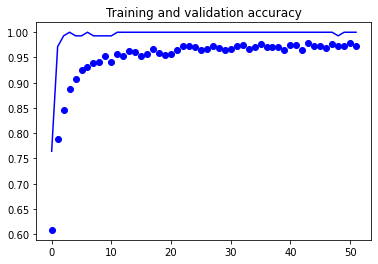

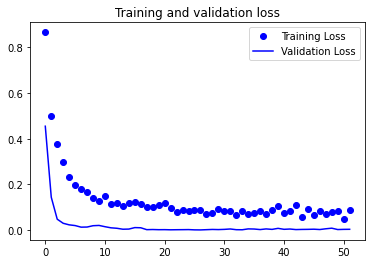

In [ ]:
import matplotlib.pyplot as plt   
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
# loading model to evaluate more depth
from keras.models import load_model
model_path = '/content/gdrive/MyDrive/Tubes/TubesRevisi2.h5'
model = load_model(model_path)

Found 194 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[97  0]
 [ 0 97]]


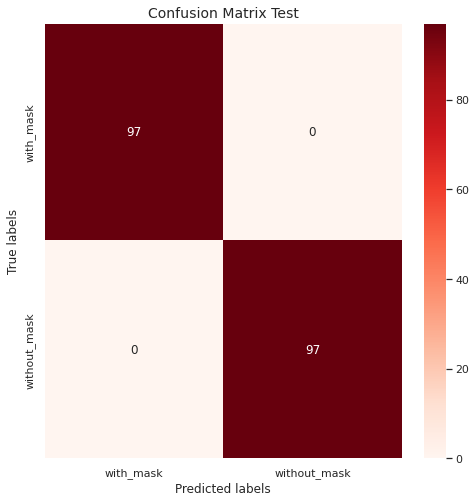

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = '/tmp/Dataset/Test'

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00        97
without_mask       1.00      1.00      1.00        97

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194

